In [ ]:
import kagglehub
dataset_path = kagglehub.dataset_download('shreelakshmigp/cedardataset')

print('Data source import complete.')

100%|██████████| 242M/242M [00:01<00:00, 167MB/s]

Extracting files...


Data source import complete.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import random
import numpy as np
import tensorflow as tf

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
os.environ['PYTHONHASHSEED'] = str(42)

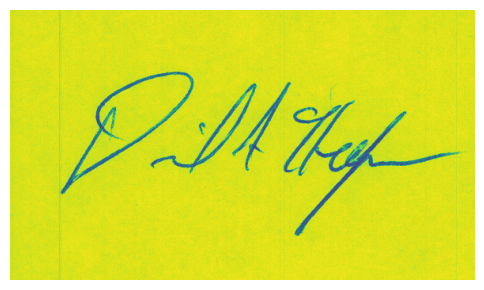

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

image_path = dataset_path + '/signatures/full_org/original_10_11.png'
img = Image.open(image_path)

plt.figure(figsize=(6, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
def load_cedar_paths(base_dir, split_writers):
    """
    Returns a dict writerID (zero-padded string) → {'orig': [orig_paths], 'forg': [forg_paths]}.
    If split_writers is None, scans both full_org and full_forg to discover all writers present.
    """
    org_dir = os.path.join(base_dir, 'full_org')
    forg_dir = os.path.join(base_dir, 'full_forg')

    paths = {}
    # For each writer, collect up to 24 samples of originals and forgeries
    for wid in split_writers:
        origs = []
        forgs = []
        # iterate sample indexes 1 through 24
        for sid in range(1, 25):
            orig_path = os.path.join(org_dir, f"original_{wid}_{sid}.png")
            forg_path = os.path.join(forg_dir, f"forgeries_{wid}_{sid}.png")
            if os.path.isfile(orig_path):
                origs.append(orig_path)
            if os.path.isfile(forg_path):
                forgs.append(forg_path)
        # only keep writers with at least one sample
        if origs or forgs:
            paths[wid] = {'orig': sorted(origs), 'forg': sorted(forgs)}
    return paths

In [ ]:
import itertools

all_ids = list(range(1, 56))
random.shuffle(all_ids)

train_ids = all_ids[:45]
val_ids = all_ids[45:50]
test_ids = all_ids[50:]

train_paths = load_cedar_paths(dataset_path + '/signatures', train_ids)
val_paths = load_cedar_paths(dataset_path + '/signatures', val_ids)
test_paths = load_cedar_paths(dataset_path + '/signatures', test_ids)

def make_balanced_pairs(paths_dict):
    positives = []
    negatives = []

    for wid, imgs in paths_dict.items():
        origs = imgs['orig']
        forgs = imgs['forg']
        # 1) Genuine vs. Genuine (same writer) → positive
        for a, b in itertools.combinations(origs, 2):
            positives.append((a, b, 1))

        # 2) Genuine vs. Forgery (same writer) → negative
        for o in origs:
            for f in forgs:
                negatives.append((o, f, 0))

    # 4) Balance counts
    n_pos = len(positives)
    n_neg = len(negatives)

    if n_neg > n_pos:
        negatives = random.sample(negatives, n_pos)
    elif n_pos > n_neg:
        positives = random.sample(positives, n_neg)

    # 5) Merge & shuffle
    pairs = positives + negatives
    random.shuffle(pairs)
    return pairs

train_pairs = make_balanced_pairs(train_paths)
val_pairs = make_balanced_pairs(val_paths)
test_pairs = make_balanced_pairs(test_paths)

In [ ]:
# Dataset creation
IMG_SIZE = (155, 220)

@tf.function
def _preprocess(path1, path2, label):
    def load_image(path):
        img = tf.io.read_file(path)
        img = tf.image.decode_png(img, channels=3)
        img = tf.image.resize(img, IMG_SIZE)
        img = tf.reshape(img, [*IMG_SIZE, 3])
        img = img / 255.0
        img = tf.image.random_brightness(img, max_delta=0.01)
        return img

    img1 = load_image(path1)
    img2 = load_image(path2)
    return (img1, img2), label

def make_dataset(pairs, batch_size=32, shuffle=True):
    paths1 = [p[0] for p in pairs]
    paths2 = [p[1] for p in pairs]
    labels = [p[2] for p in pairs]

    ds = tf.data.Dataset.from_tensor_slices((paths1, paths2, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(labels))
    ds = ds.map(_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_dataset(train_pairs, batch_size=64, shuffle=True)
val_ds = make_dataset(val_pairs, batch_size=64, shuffle=False)
test_ds = make_dataset(test_pairs, batch_size=64, shuffle=False)

Image shape: (155, 220, 3)
Label: 0


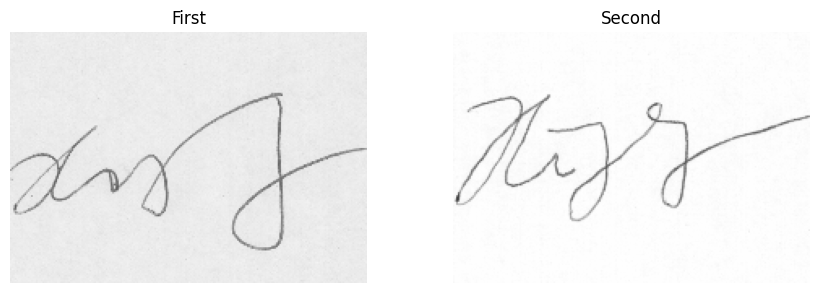

In [ ]:
# Visualize sample
for (img_pair, label) in train_ds.take(1):
    first_img = img_pair[0][3]
    second_img = img_pair[1][3]
    label_value = label[3]
    print(f"Image shape: {first_img.shape}")
    print(f"Label: {label_value}")
    break

plt.figure(figsize=(9, 3))

plt.subplot(1, 2, 1)
plt.imshow(first_img, cmap='gray')
plt.title("First")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(second_img, cmap='gray')
plt.title("Second")
plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras import layers, Model
import tensorflow as tf

class L1DistanceLayer(layers.Layer):
    """Custom layer to compute L1 distance between two embeddings."""

    def __init__(self, **kwargs):
        super(L1DistanceLayer, self).__init__(**kwargs)

    def call(self, inputs):
        emb_a, emb_b = inputs
        diff = tf.abs(emb_a - emb_b)
        distance = tf.reduce_sum(diff, axis=1, keepdims=True)
        return distance

    def get_config(self):
        return super(L1DistanceLayer, self).get_config()

def make_embedding_net(input_shape=(155, 220, 3), embedding_dim=128):
    """Create embedding network for feature extraction."""
    inp = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, (10, 10), activation='relu')(inp)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, (7, 7), activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, (4, 4), activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(256, (4, 4), activation='relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(embedding_dim, activation='sigmoid')(x)
    return Model(inp, x, name='EmbeddingNet')

def contrastive_loss(margin=1.0):
    """Contrastive loss function for siamese network."""
    def loss(y_true, y_pred):
        # y_pred = L1 distance between embeddings
        squared = tf.square(y_pred)
        margin_sq = tf.square(tf.maximum(margin - y_pred, 0))
        return tf.reduce_mean(y_true * squared + (1 - y_true) * margin_sq)
    return loss

In [ ]:
# Build Siamese model architecture
embed_net = make_embedding_net()

inp_a = layers.Input((155, 220, 3), name='input_a')
inp_b = layers.Input((155, 220, 3), name='input_b')

emb_a = embed_net(inp_a)
emb_b = embed_net(inp_b)

distance = L1DistanceLayer(name='l1_distance')([emb_a, emb_b])

siamese_model = Model([inp_a, inp_b], distance, name='SiameseNet')

opt = tf.keras.optimizers.Adam(learning_rate=5e-4)
siamese_model.compile(
    optimizer=opt,
    loss=contrastive_loss(margin=1.0)
)

print("Model architecture:")
siamese_model.summary()

Model architecture:


Model: "SiameseNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_a             │ (None, 155, 220,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_b             │ (None, 155, 220,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ EmbeddingNet        │ (None, 128)       │  9,072,064 │ input_a[0][0],    │
│ (Functional)        │                   │            │ input_b[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_distance         │ (None, 1)         │          0 │ EmbeddingNet[0][… │
│ (L1DistanceLayer)   │                   │            │ EmbeddingNet[1][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,072,064 (34.61 MB)

 Trainable params: 9,072,064 (34.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/drive/MyDrive/signature_verification_model_production.keras',
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Train the model
history = siamese_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/10
389/389 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - loss: 0.0487
Epoch 1: val_loss improved from inf to 0.03363, saving model to /content/drive/MyDrive/signature_verification_model_production.keras
389/389 ━━━━━━━━━━━━━━━━━━━━ 235s 545ms/step - loss: 0.0487 - val_loss: 0.0336
Epoch 2/10
389/389 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - loss: 0.0316
Epoch 2: val_loss improved from 0.03363 to 0.03141, saving model to /content/drive/MyDrive/signature_verification_model_production.keras
389/389 ━━━━━━━━━━━━━━━━━━━━ 207s 458ms/step - loss: 0.0316 - val_loss: 0.0314
Epoch 3/10
389/389 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - loss: 0.0170
Epoch 3: val_loss improved from 0.03141 to 0.02901, saving model to /content/drive/MyDrive/signature_verification_model_production.keras
389/389 ━━━━━━━━━━━━━━━━━━━━ 185s 475ms/step - loss: 0.0170 - val_loss: 0.0290
Epoch 4/10
389/389 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - loss: 0.0120
Epoch 4: val_loss did not improve from 0.02901
389/389 ━━━━━━━━━━━━━━━━━━━━ 194s

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, roc_curve, auc

def compute_accuracy_at_threshold(model, dataset, threshold):
    """Compute accuracy at a given threshold."""
    all_dists, all_labels = [], []
    for (img1, img2), label in dataset:
        d_batch = model.predict([img1, img2], verbose=0)
        all_dists.extend(d_batch.ravel())
        all_labels.extend(label.numpy().ravel())

    dists = np.array(all_dists)
    labs = np.array(all_labels)
    preds = (dists < threshold).astype(int)
    return accuracy_score(labs, preds)

# Evaluate model
th = 0.5
acc_train = compute_accuracy_at_threshold(siamese_model, train_ds, th)
acc_val = compute_accuracy_at_threshold(siamese_model, val_ds, th)
acc_test = compute_accuracy_at_threshold(siamese_model, test_ds, th)

print(f"Threshold = {th:.3f}")
print(f"Train Accuracy = {acc_train*100:.2f}%")
print(f"Val Accuracy   = {acc_val*100:.2f}%")
print(f"Test Accuracy  = {acc_test*100:.2f}%")

Threshold = 0.500
Train Accuracy = 100.00%
Val Accuracy   = 98.99%
Test Accuracy  = 98.19%


ROC AUC = 0.9976


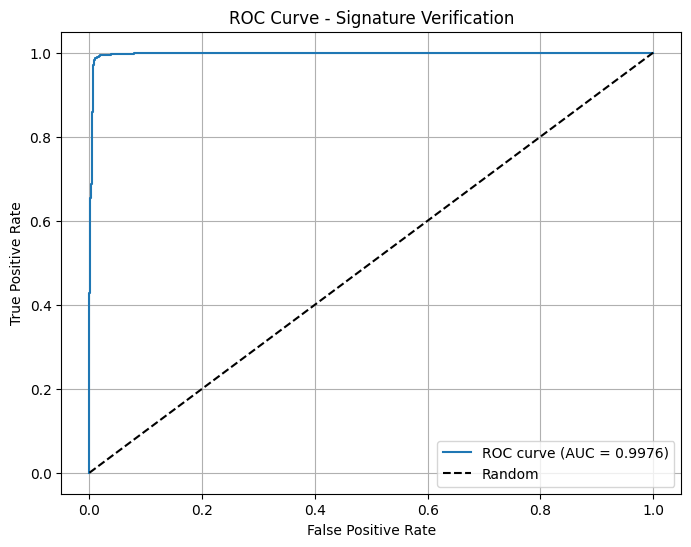

In [ ]:
# ROC Analysis
all_distances = []
all_labels = []

for (img1, img2), label in test_ds:
    d_batch = siamese_model.predict([img1, img2], verbose=0)
    all_distances.extend(d_batch.ravel())
    all_labels.extend(label.numpy().ravel())

all_distances = np.array(all_distances)
all_labels = np.array(all_labels)

# Convert distances to similarity scores (negative distance)
scores = -all_distances

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(all_labels, scores)
roc_auc = auc(fpr, tpr)

print(f"ROC AUC = {roc_auc:.4f}")

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Signature Verification')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
import cv2

class SignatureVerifier:
    """signature verification class."""

    def __init__(self, model_path=None, model=None):
        """Initialize with either model path or model object."""
        if model is not None:
            self.model = model
        elif model_path is not None:
            self.model = self.load_model_safe(model_path)
        else:
            raise ValueError("Either model_path or model must be provided")

    @staticmethod
    def load_model_safe(model_path):
        """Safely load model with custom objects."""
        try:
            custom_objects = {'L1DistanceLayer': L1DistanceLayer}

            model = tf.keras.models.load_model(
                model_path,
                custom_objects=custom_objects,
                compile=False
            )
            return model
        except Exception as e:
            print(f"Error loading model: {e}")
            raise

    def preprocess_signature(self, img_path, target_size=(220, 155)):
        """Preprocess signature image for model input."""
        try:
            img = cv2.imread(img_path)
            if img is None:
                raise FileNotFoundError(f"Image not found: {img_path}")

            img = cv2.resize(img, target_size)
            img = img.astype("float32") / 255.0
            return img
        except Exception as e:
            print(f"Error preprocessing image {img_path}: {e}")
            raise

    def verify_signatures(self, sig1_path, sig2_path, threshold=0.5):
        """
        Compare two signatures and return distance, similarity, and decision.

        Returns:
            dict: {
                'distance': float,
                'similarity': float (0-1, higher = more similar),
                'decision': str,
                'confidence': float
            }
        """
        try:
            # Preprocess images
            sig1 = self.preprocess_signature(sig1_path)
            sig2 = self.preprocess_signature(sig2_path)

            # Add batch dimension
            sig1 = np.expand_dims(sig1, axis=0)
            sig2 = np.expand_dims(sig2, axis=0)

            # Predict distance
            distance = self.model.predict([sig1, sig2], verbose=0)[0][0]

            # Convert distance to similarity (0-1 scale)
            # Lower distance = higher similarity
            similarity = max(0, 1 - distance)

            # Make decision
            is_same = distance < threshold
            decision = "Same Person" if is_same else "Different Person"

            # Calculate confidence (distance from threshold)
            confidence = abs(distance - threshold) / threshold
            confidence = min(1.0, confidence)

            return {
                'distance': float(distance),
                'similarity': float(similarity),
                'decision': decision,
                'confidence': float(confidence)
            }

        except Exception as e:
            print(f"Error during verification: {e}")
            return None

    def batch_verify(self, signature_pairs, threshold=0.5):
        """Verify multiple signature pairs at once."""
        results = []
        for sig1_path, sig2_path in signature_pairs:
            result = self.verify_signatures(sig1_path, sig2_path, threshold)
            if result:
                result['pair'] = (sig1_path, sig2_path)
                results.append(result)
        return results

In [ ]:


# Save the trained model
siamese_model.save('/content/drive/MyDrive/signature_verification_model_production.keras')

# Initialize verifier with trained model
verifier = SignatureVerifier(model=siamese_model)

# Test verification
wid = 10
sid1 = 2
sid2 = 11
sig1 = dataset_path + f"/signatures/full_org/original_{wid}_{sid1}.png"
sig2 = dataset_path + f"/signatures/full_org/original_{wid}_{sid2}.png"

print("=== Signature Verification Test ===")
result = verifier.verify_signatures(sig1, sig2, threshold=0.5)

if result:
    print(f"Distance: {result['distance']:.4f}")
    print(f"Similarity: {result['similarity']:.4f}")
    print(f"Decision: {result['decision']}")
    print(f"Confidence: {result['confidence']:.4f}")
else:
    print("Verification failed")



try:
    loaded_verifier = SignatureVerifier(
        model_path='/content/drive/MyDrive/signature_verification_model_production.keras'
    )

    # Test loaded model
    result_loaded = loaded_verifier.verify_signatures(sig1, sig2, threshold=0.5)
    print("Model loaded and verified successfully!")
    print(f"Loaded model result: {result_loaded}")

except Exception as e:
    print(f"Error loading model: {e}")

=== Signature Verification Test ===
Distance: 0.0532
Similarity: 0.9468
Decision: Same Person
Confidence: 0.8935

=== Testing Model Loading ===
Model loaded and verified successfully!
Loaded model result: {'distance': 0.05323190614581108, 'similarity': 0.9467681050300598, 'decision': 'Same Person', 'confidence': 0.8935362100601196}
